In [1]:
import aicspylibczi
import pathlib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Reading a portion of a large multiscene image

## Load a 1.13 TB file

In [2]:
pth = pathlib.Path('20180423_M02_002.czi')
pth.stat().st_size/(1024*1024*1024)

44.182542115449905

In [3]:
czi = aicspylibczi.CziFile(pth)

## Get the shape of the data in the file

In [4]:
czi.dims

'BSCZYX'

In [5]:
czi.size

(1, 40, 4, 60, 1300, 1900)

In [6]:
czi.dims_shape()

{'B': (0, 0),
 'C': (0, 3),
 'S': (0, 39),
 'X': (0, 1899),
 'Y': (0, 1299),
 'Z': (0, 59)}

## Load all channels of a specific image slice

In [7]:
img, shp = czi.read_image(S=13, Z=16) 

## The shp object gives the order and size of the dimensions of the numpy.ndarray
### Note in dims shape above it's returning the Range for each Dimension here it's returning the size

In [8]:
shp

[('B', 1), ('S', 1), ('C', 4), ('Z', 1), ('Y', 1300), ('X', 1900)]

In [9]:
img.shape

(1, 1, 4, 1, 1300, 1900)

## Normalize the image so it displays sensibly

In [10]:
def norm_by( x):
    norms = np.percentile(x, [50, 99.8])
    i2 = np.clip((x - norms[0])/(norms[1]-norms[0]), 0, 1)
    i2
    return i2

In [11]:
def recolor( im): # transform from rgb to cyan-magenta-yellow
    im_shape = np.array(im.shape)
    color_transform = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]]).T
    im_reshape = im.reshape([np.prod(im_shape[0:2]), im_shape[2]]).T
    im_recolored = np.matmul(color_transform.T, im_reshape).T
    im_shape[2] = 3
    im = im_recolored.reshape(im_shape)
    return im

### normalize, combine into RGB and transform to CMY

In [12]:
c1 = (norm_by(img[0, 0, 0, 0, 0:750, 250:1000])*255).astype(np.uint8)
c2 = (norm_by(img[0, 0, 1, 0, 0:750, 250:1000])*255).astype(np.uint8)
c3 = (norm_by(img[0, 0, 2, 0, 0:750, 250:1000])*255).astype(np.uint8)
rgb = np.stack((c1, c2, c3), axis=2)
cmy = np.clip(recolor(rgb), 0, 255)

### plot using matplotlib

(-0.5, 749.5, 749.5, -0.5)

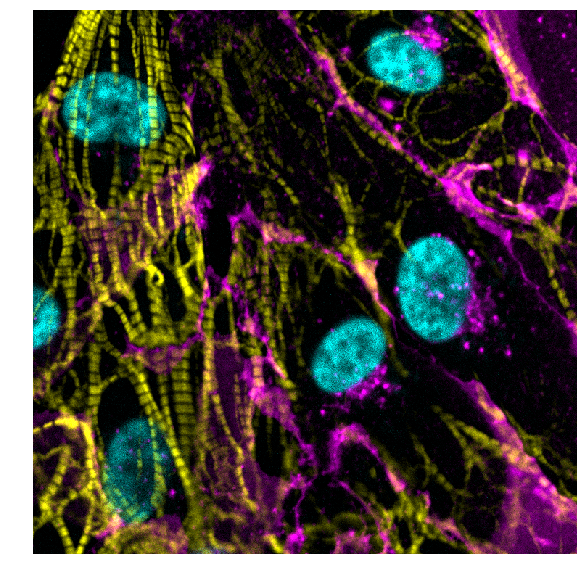

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(cmy)
plt.axis('off')

___

# Reading a large mosaic file

A mosaic file is an aquisition mode in which the microscope tiles a space to create a large composite image.

## Load a 27 GB mosaic file

In [14]:
pTwo = pathlib.Path('mosaic_test.czi')
pTwo.stat().st_size/(1024*1024*1024)

0.0025993287563323975

In [15]:
cziTwo = aicspylibczi.CziFile(pTwo)

## Get the shape of the mosaic file 
Note the M index is introduced as a psudo-Dimension to allow access to the data, for read_mosaic below you shouldn't have to care but if you wanted to use read_image to look at the individual subblock images you could specify select specific frames using m_index parameter or by pulling them all and navigating the M dimension in the numpy.ndarray that comes back.

In [16]:
cziTwo.dims

'STCZMYX'

In [17]:
cziTwo.size

(1, 1, 1, 1, 2, 624, 924)

In [18]:
cziTwo.dims_shape()

{'C': (0, 0),
 'M': (0, 1),
 'S': (0, 0),
 'T': (0, 0),
 'X': (0, 923),
 'Y': (0, 623),
 'Z': (0, 0)}

## Check it is a mosaic file

In [19]:
cziTwo.is_mosaic()

True

## Get the images full shape
x, y is the upper left coorinate image based coordinate system

In [20]:
sze = cziTwo.read_mosaic_size()
(sze.x, sze.y, sze.w, sze.h)

(0, 0, 1756, 624)

## Read the mosaic file

Note mosaic files as shown above have a Scene index but are not meant to be reassabled using that constraint they internally use an M-Index instead. Consequently when attempting to specify the 2D plane you want lock in all dimensions larger than 1 except scene. The scale_factor below loads a w/10 by h/10 version of the image (ie 1/100th of the original number of pixels).

In [21]:
icOne = cziTwo.read_mosaic(C=0, scale_factor=1.0)

In [22]:
icOne.shape

(1, 1, 624, 1756)

## Scale and render the mosaic file

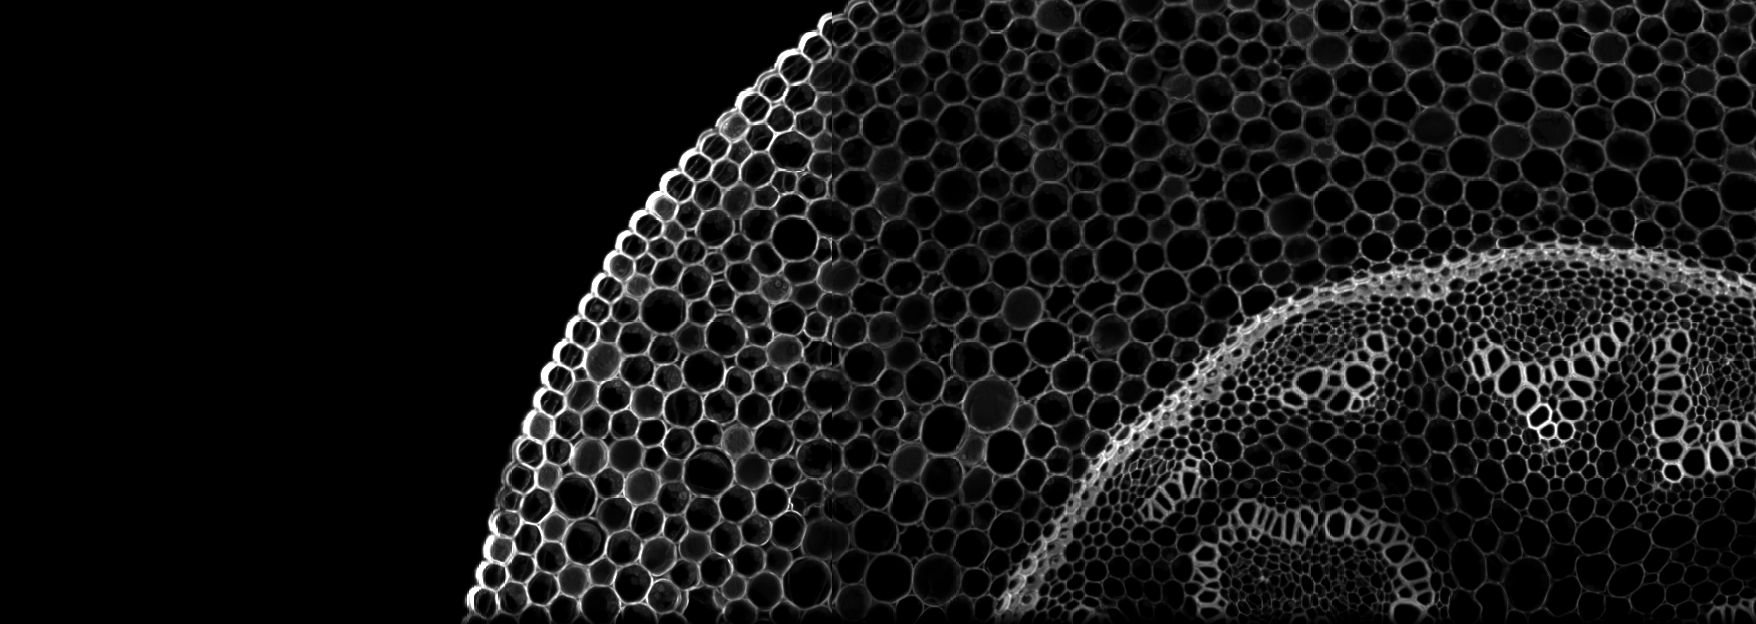

In [23]:
itwo = icOne[0,0,:, :]
itwonorm = norm_by(itwo)*255
Image.fromarray(itwonorm.astype(np.uint8))